In [1]:
from profiler import Profiler, ListEvents
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, time
from matplotlib import pyplot as plt

In [2]:
flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

In [3]:
all_events= ListEvents().get_event_description()
software_events= [e[0] for e in all_events if 'PERF_COUNT_SW' in e[0]]
hardware_events= [e[0] for e in all_events if 'PERF_COUNT_HW' in e[0]]
mem_events=[e[0] for e in all_events if 'MEM' in e[0] or 'CACHE' in e[0]]
rapl_events=['SYSTEMWIDE:'+e[0] for e in all_events if 'RAPL' in e[0]]
#hw_groups= split_n(hardware_events, 5)
#ListEvents().get_event_attrs('FP_COMP_OPS_EXE')
#display(all_events)
#ListEvents().get_event_attrs('UOPS_EXECUTED')

In [4]:
#ListEvents().get_event_attrs('FP_COMP_OPS_EXE')

<a href="http://uops.info/table.html">UOPS- micro operations</a>
<p></p>
<img src="pipeline.png" width=340> </img>
<p></p>
<p>Manually tested events:</p>
<p>PERF_COUNT_HW_INSTRUCTIONS</p>
<p>MEM_UOPS_RETIRED:ALL_STORES</p>
<p>FP_COMP_OPS_EXE</p>

In [4]:
# ARITH UOPS_EXECUTED:CORE MEM_LOAD_RETIRED
mem_events= double_list(['MEM_UOPS_RETIRED:ALL_LOADS', 'MEM_UOPS_RETIRED:ALL_STORES'])
hw_events= double_list(['PERF_COUNT_HW_INSTRUCTIONS','PERF_COUNT_HW_BRANCH_INSTRUCTIONS','FP_COMP_OPS_EXE:X87',
                       'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'])
sw_events= [['PERF_COUNT_SW_CPU_CLOCK','PERF_COUNT_SW_PAGE_FAULTS','PERF_COUNT_SW_CONTEXT_SWITCHES',
                       'PERF_COUNT_SW_CPU_MIGRATIONS','PERF_COUNT_SW_PAGE_FAULTS_MAJ']]
to_monitor= hw_events+mem_events+sw_events+double_list(rapl_events)

In [5]:
dfs= []
pname= 'covariance_MEDIUM_DATASET' # ./hello
try:
    for i in tqdm(range(30)):
        program= Profiler(program_args=['polybench/'+pname], events_groups=to_monitor)
        data= program.run(sample_period=0.05,reset_on_sample=True)
        dfs.append(pd.DataFrame(data, columns=flat_list(to_monitor)))
except RuntimeError as e:
    print(e.args[0])

100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


In [20]:
dfs[0].tail(5)

,PERF_COUNT_HW_INSTRUCTIONS,PERF_COUNT_HW_BRANCH_INSTRUCTIONS,FP_COMP_OPS_EXE:X87,PERF_COUNT_HW_BRANCH_MISSES,PERF_COUNT_HW_CACHE_MISSES,MEM_UOPS_RETIRED:ALL_LOADS,MEM_UOPS_RETIRED:ALL_STORES,PERF_COUNT_SW_CPU_CLOCK,PERF_COUNT_SW_PAGE_FAULTS,PERF_COUNT_SW_CONTEXT_SWITCHES,PERF_COUNT_SW_CPU_MIGRATIONS,PERF_COUNT_SW_PAGE_FAULTS_MAJ,SYSTEMWIDE:RAPL_ENERGY_CORES,SYSTEMWIDE:RAPL_ENERGY_PKG,SYSTEMWIDE:RAPL_ENERGY_DRAM
0,642928356,31164964,499938,79248,19436,277297570,31118374,88292465,524,0,0,0,12254052352,16303783936,0
1,342986058,24945762,558741,185329,2747,148660486,22762736,89776415,82,0,0,0,13542817792,17560895488,0
2,46526566,9308457,535277,142472,267,12325759,7223874,47014143,1,0,0,0,11559763968,15560736768,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


100%|██████████| 15/15 [00:03<00:00,  4.99it/s]


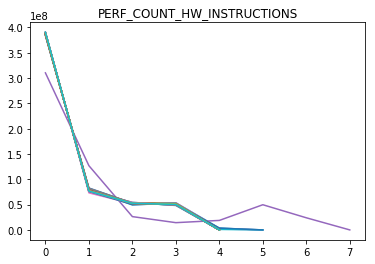

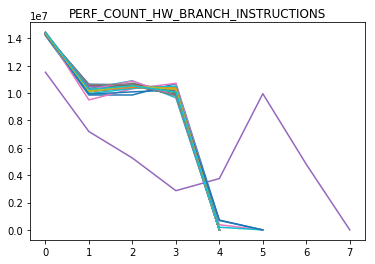

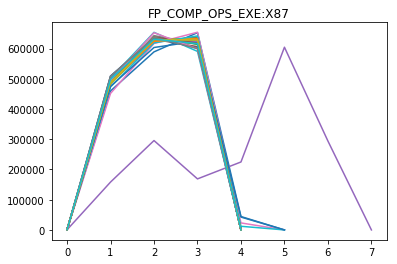

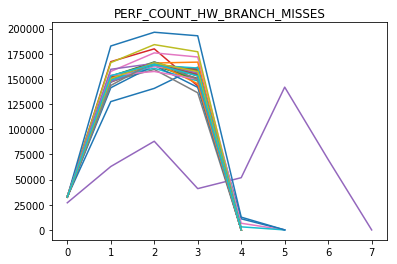

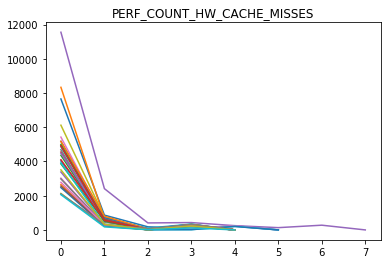

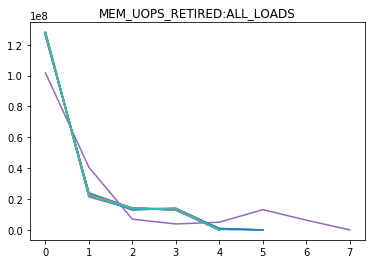

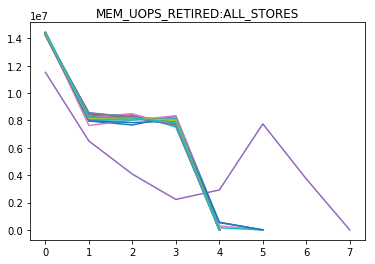

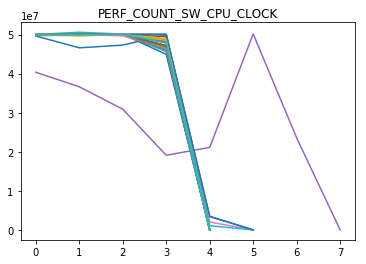

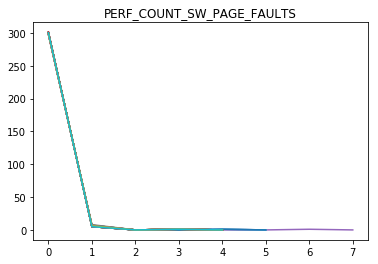

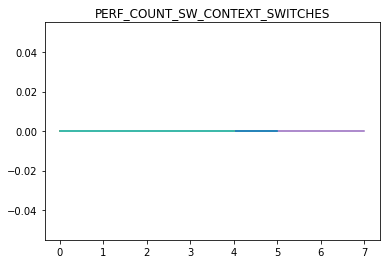

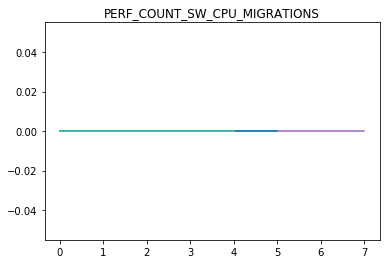

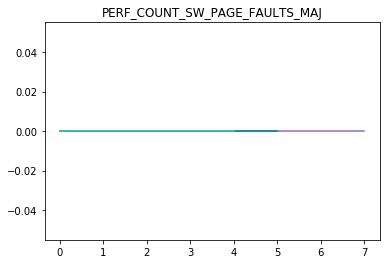

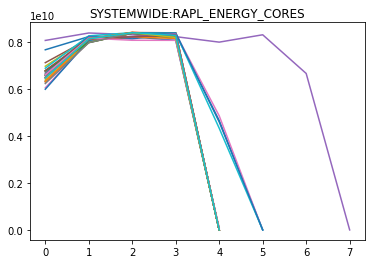

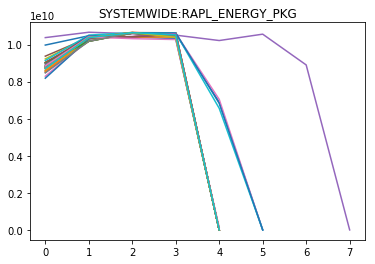

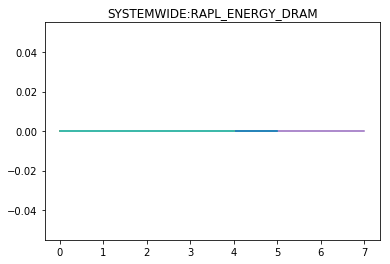

In [6]:
for c in tqdm(dfs[0].columns):
    plt.figure()
    for df in dfs:
        df[c].plot()
        plt.title(c)

/home/vitor/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


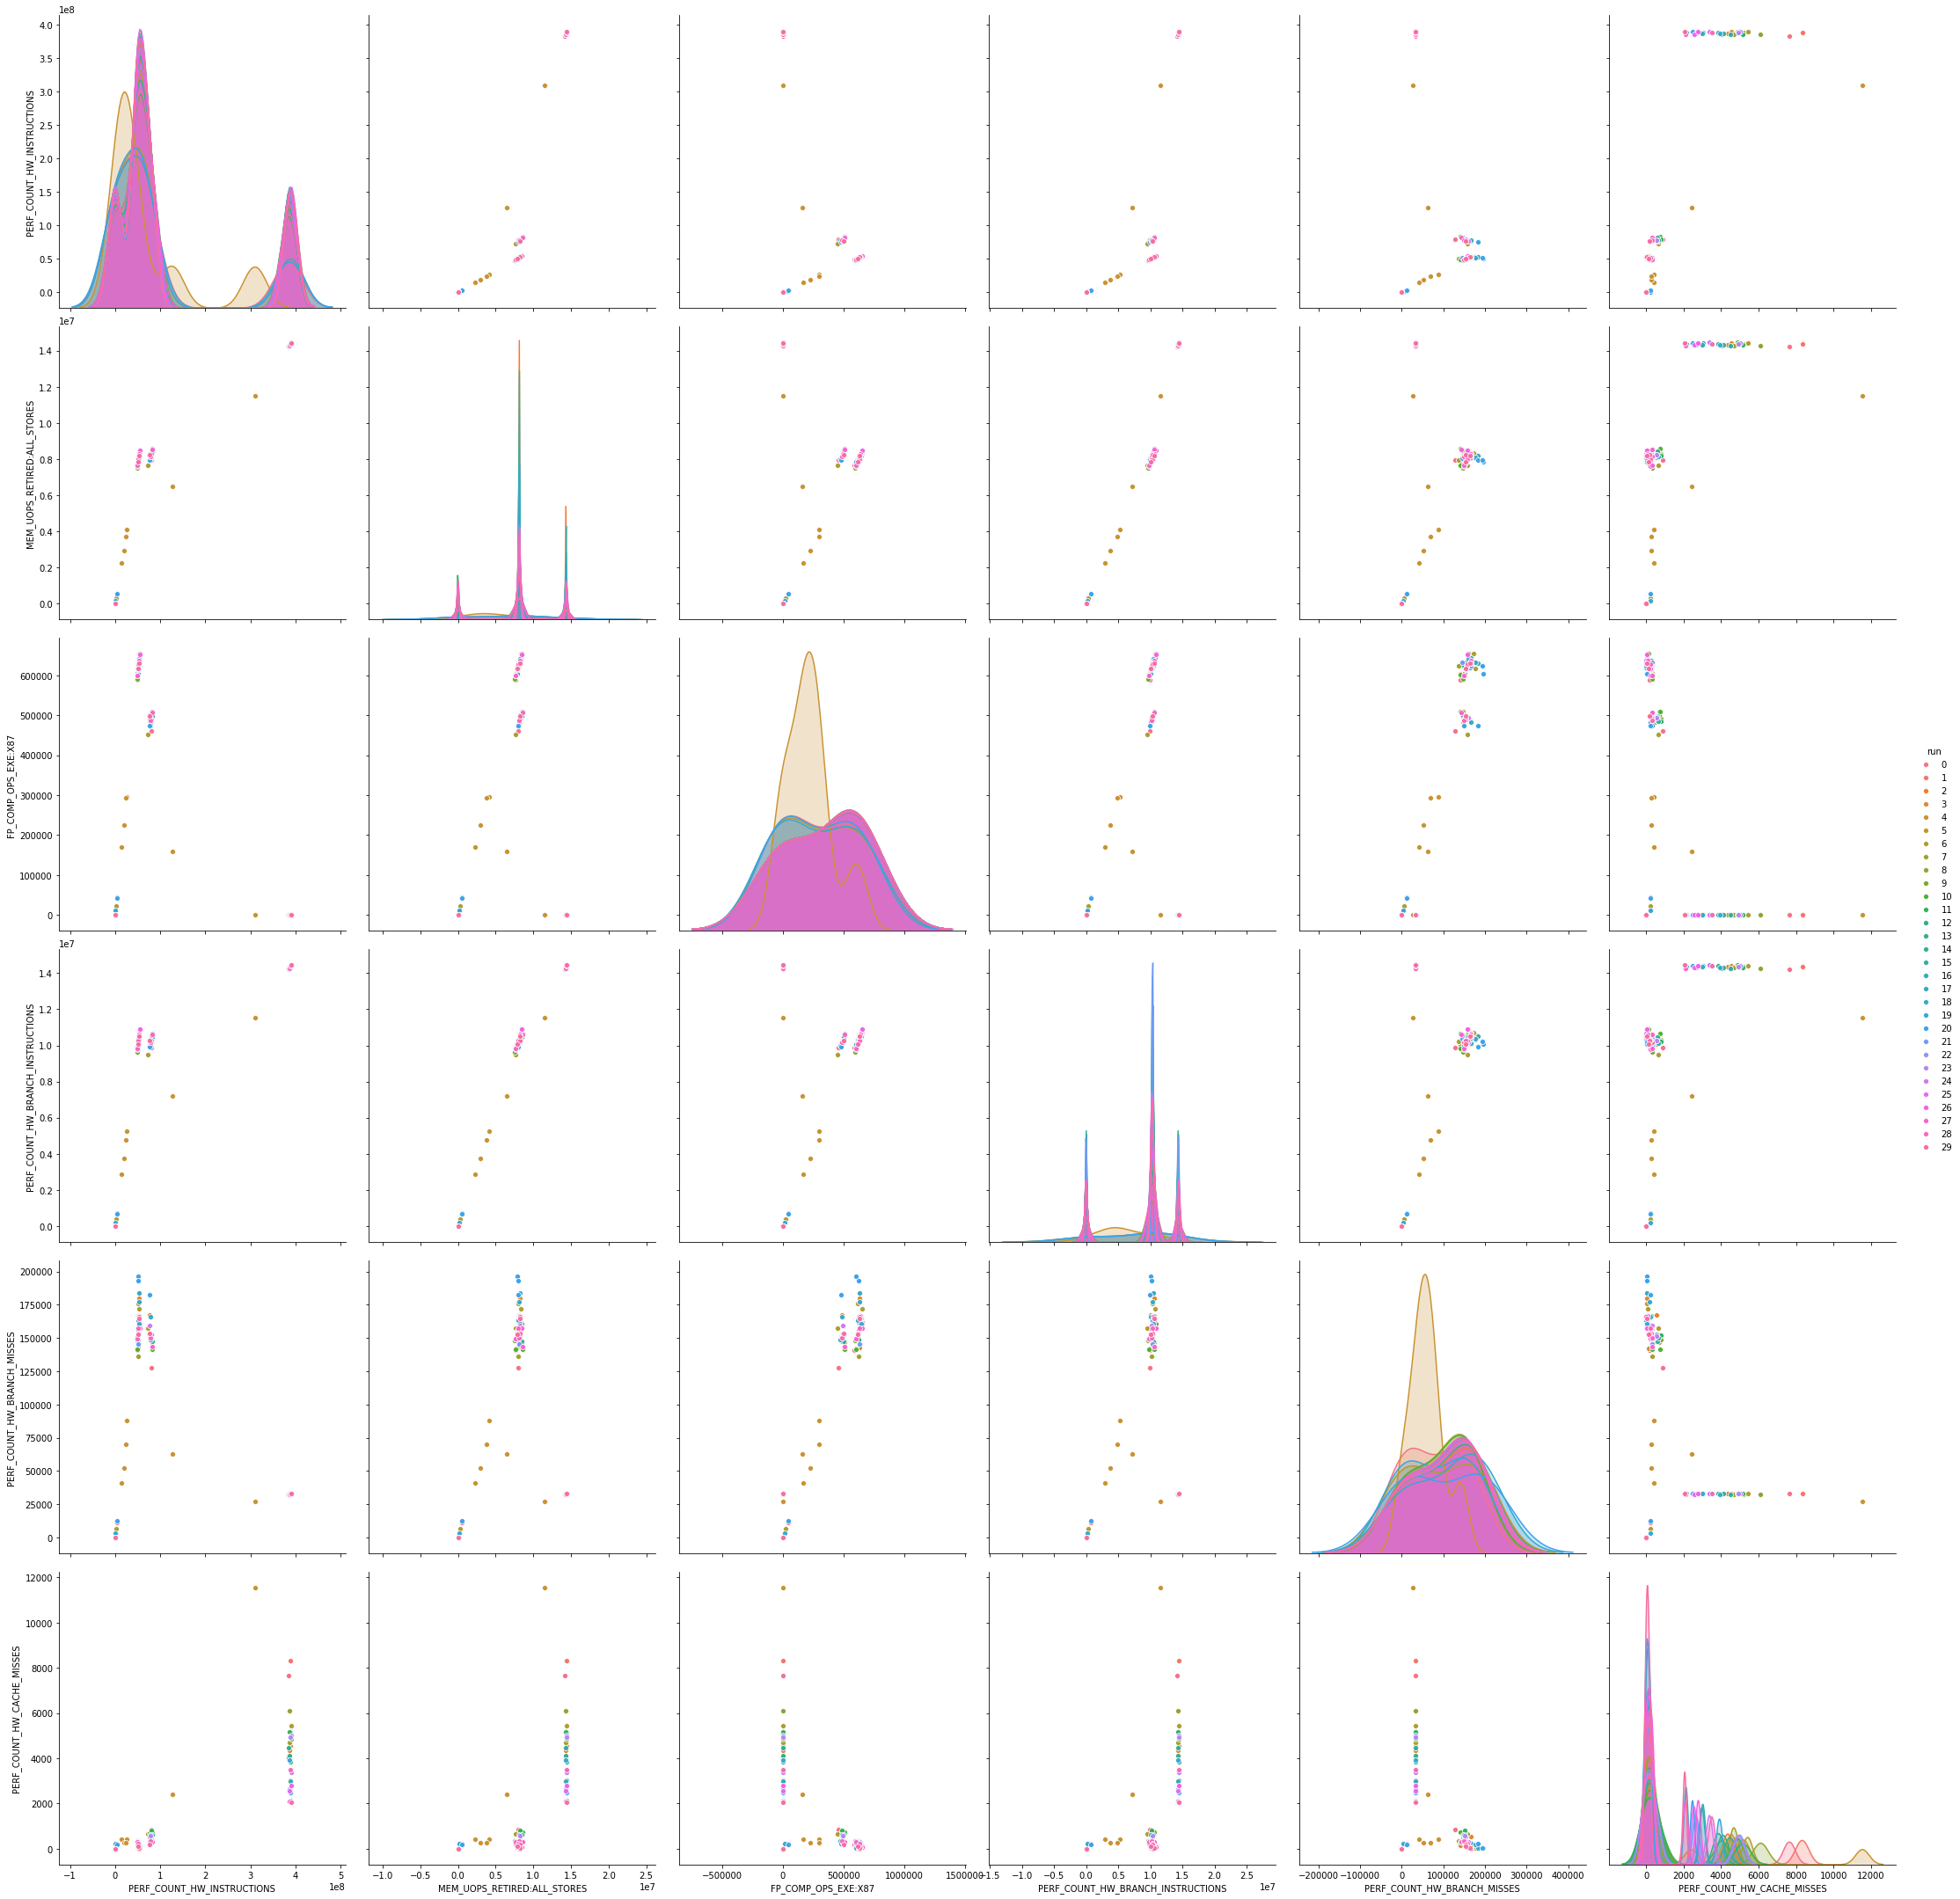

In [8]:
big_df=pd.DataFrame()
for i, df in enumerate(dfs):
    df['run']= i
    big_df= pd.concat([big_df,df])
big_df.head(5)
import seaborn as sns
sns_plot= sns.pairplot(big_df,vars=['PERF_COUNT_HW_INSTRUCTIONS','MEM_UOPS_RETIRED:ALL_STORES','FP_COMP_OPS_EXE:X87',
                                   'PERF_COUNT_HW_BRANCH_INSTRUCTIONS', 'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'], hue="run",size=5)
#sns_plot.savefig("output.png")